# XGBoost for modelling specific mass balance 

In [1]:
# Import libraries
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import shap
from yellowbrick.regressor import ResidualsPlot

In [493]:
# Import dataframe
df2000_2020 = pd.read_csv('C:/Users/david/Documents/Thesis/Data/df2000_2020_imp.csv')

numerical = df2000_2020[['velocity_mean','avg_ice_thickness', 'debris_area_ela_p',
       'Slope', 'Aspect', 'Area', 'Zmed', 'ice_volume','debris_vol_ela_p',
       'tstar_aar', 'temp_diff_2000_2020', 'temp_mean_2000_2020',
       'prcp_diff_2000_2020', 'prcp_mean_2000_2020','temp_diff_1980-2000','prcp_diff_1980_2000']]
list_numerical = numerical.columns
df = pd.concat([df2000_2020[['dmdtda','dvoldt', 'glacial_lake','surging']],numerical], axis=1)

# Z-score the independent numerical variables
scaler = StandardScaler().fit(df2000_2020[list_numerical]) 

df[list_numerical] = scaler.transform(df[list_numerical])

df = df.dropna(how='any',axis=0) 
df

# Labels are the values we want to predict
y = np.array(df['dmdtda'])

X = df[['avg_ice_thickness','Area', 'debris_area_ela_p', 'velocity_mean',
       'Slope', 'Aspect', 'Zmed', 'tstar_aar', 'temp_diff_2000_2020',
       'temp_mean_2000_2020', 'prcp_diff_2000_2020', 'prcp_mean_2000_2020',
       'temp_diff_1980-2000', 'prcp_diff_1980_2000',
                'glacial_lake', 'surging']]
# Saving feature names for later use
feature_list = list(X.columns)

In [127]:
# Using Skicit-learn to split data into training and testing sets
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

## Tune parameters of XGBoost model with GridSearchCV

#### Step 1: Tune max_depth and min_child_weight


In [21]:
# Source: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

# Instantiate the regressor: model
model = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

param_grid = {
     'max_depth':range(3,10,1),
     'min_child_weight':range(1,6,1)

}

# Perform grid search: 
grid_search = GridSearchCV(estimator=model,
param_grid=param_grid, scoring='neg_mean_squared_error', cv=4, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_

# Print the best parameters and lowest MAE
print("Best parameters found: ", grid_search.best_params_)
print("Lowest MSE found: ", np.sqrt(np.abs(grid_search.best_score_)))

# Optimal values:
# Max depth: 9
# Min_child_weight: 1

Fitting 4 folds for each of 35 candidates, totalling 140 fits
[CV] END ....................max_depth=3, min_child_weight=1; total time=   1.5s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   1.6s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   1.5s
[CV] END ....................max_depth=3, min_child_weight=1; total time=   1.5s
[CV] END ....................max_depth=3, min_child_weight=2; total time=   1.5s
[CV] END ....................max_depth=3, min_child_weight=2; total time=   1.6s
[CV] END ....................max_depth=3, min_child_weight=2; total time=   1.7s
[CV] END ....................max_depth=3, min_child_weight=2; total time=   1.7s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   1.6s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   1.6s
[CV] END ....................max_depth=3, min_child_weight=3; total time=   1.6s
[CV] END ....................max_depth=3, min_c

### # Step 2: Tune gamma

In [23]:
# Instantiate the regressor: model
model = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

param_grid = {
     'gamma':[i/10.0 for i in range(0,5)]
}

# Perform grid search: grid_mse
grid_search = GridSearchCV(estimator=model,
param_grid=param_grid, scoring='neg_mean_squared_error', cv=4, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_
# Print the best parameters and lowest MAE
print("Best parameters found: ", grid_search.best_params_)
print("Lowest MSE found: ", np.sqrt(np.abs(grid_search.best_score_)))

# Gamma: 0

Fitting 4 folds for each of 5 candidates, totalling 20 fits
[CV] END ..........................................gamma=0.0; total time=   4.9s
[CV] END ..........................................gamma=0.0; total time=   5.1s
[CV] END ..........................................gamma=0.0; total time=   6.7s
[CV] END ..........................................gamma=0.0; total time=   6.5s
[CV] END ..........................................gamma=0.1; total time=   6.5s
[CV] END ..........................................gamma=0.1; total time=   6.7s
[CV] END ..........................................gamma=0.1; total time=   6.4s
[CV] END ..........................................gamma=0.1; total time=   6.5s
[CV] END ..........................................gamma=0.2; total time=   6.6s
[CV] END ..........................................gamma=0.2; total time=   7.5s
[CV] END ..........................................gamma=0.2; total time=   6.9s
[CV] END ........................................

### # Step 3: Tune subsample and colsample_bytree


In [25]:
# Instantiate the regressor: model
model = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

param_grid = {
     'subsample':[i/10.0 for i in range(6,10)],
     'colsample_bytree':[i/10.0 for i in range(6,10)]
}

# Perform grid search: grid_mse
grid_search = GridSearchCV(estimator=model,
param_grid=param_grid, scoring='neg_mean_squared_error', cv=4, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_
# Print the best parameters and lowest MAE
print("Best parameters found: ", grid_search.best_params_)
print("Lowest MSE found: ", np.sqrt(np.abs(grid_search.best_score_)))

# colsample_bytree: 0.7
# subsample: 0.6

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time=   4.3s
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time=   4.9s
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time=   5.5s
[CV] END ................colsample_bytree=0.6, subsample=0.6; total time=   4.9s
[CV] END ................colsample_bytree=0.6, subsample=0.7; total time=   5.3s
[CV] END ................colsample_bytree=0.6, subsample=0.7; total time=   5.4s
[CV] END ................colsample_bytree=0.6, subsample=0.7; total time=   5.0s
[CV] END ................colsample_bytree=0.6, subsample=0.7; total time=   6.2s
[CV] END ................colsample_bytree=0.6, subsample=0.8; total time=   5.1s
[CV] END ................colsample_bytree=0.6, subsample=0.8; total time=   5.2s
[CV] END ................colsample_bytree=0.6, subsample=0.8; total time=   5.3s
[CV] END ................colsample_bytree=0.6, s

### Step 4: Tuning Regularization Parameters

In [32]:
# Instantiate the regressor: model
model = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

param_grid = {
     'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}

# Perform grid search: grid_mse
grid_search = GridSearchCV(estimator=model,
param_grid=param_grid, scoring='neg_mean_absolute_error', cv=4, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_
# Print the best parameters and lowest MAE
print("Best parameters found: ", grid_search.best_params_)
print("Lowest MAE found: ", np.sqrt(np.abs(grid_search.best_score_)))

# reg_alpha: 0.01

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV] END ........................................reg_alpha=0; total time=   4.4s
[CV] END ........................................reg_alpha=0; total time=   4.7s
[CV] END ........................................reg_alpha=0; total time=   4.8s
[CV] END ........................................reg_alpha=0; total time=   5.5s
[CV] END ....................................reg_alpha=1e-05; total time=   7.0s
[CV] END ....................................reg_alpha=1e-05; total time=   6.4s
[CV] END ....................................reg_alpha=1e-05; total time=   5.3s
[CV] END ....................................reg_alpha=1e-05; total time=   5.3s
[CV] END .....................................reg_alpha=0.01; total time=   5.2s
[CV] END .....................................reg_alpha=0.01; total time=   5.4s
[CV] END .....................................reg_alpha=0.01; total time=   5.1s
[CV] END .....................................reg

In [117]:
# Step 4.5: Tuning Regularization Parameters

# Instantiate the regressor: model
model = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=3,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.8,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

param_grid = {
     'reg_alpha':[0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
}

# Perform grid search: grid_mse
grid_search = GridSearchCV(estimator=model,
param_grid=param_grid, scoring='neg_mean_absolute_error', cv=4, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_
# Print the best parameters and lowest MAE
print("Best parameters found: ", grid_search.best_params_)
print("Lowest MAE found: ", np.sqrt(np.abs(grid_search.best_score_)))

# reg_alpha: 0.05

Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV] END ........................................reg_alpha=0; total time=   4.6s
[CV] END ........................................reg_alpha=0; total time=   5.0s
[CV] END ........................................reg_alpha=0; total time=   5.7s
[CV] END ........................................reg_alpha=0; total time=   5.6s
[CV] END ...................................reg_alpha=0.0001; total time=   5.5s
[CV] END ...................................reg_alpha=0.0001; total time=   5.6s
[CV] END ...................................reg_alpha=0.0001; total time=   5.5s
[CV] END ...................................reg_alpha=0.0001; total time=   5.6s
[CV] END ...................................reg_alpha=0.0005; total time=   5.6s
[CV] END ...................................reg_alpha=0.0005; total time=   5.6s
[CV] END ...................................reg_alpha=0.0005; total time=   5.5s
[CV] END ...................................reg_a

### Step 5: Tuning Regularization Parameters: reg_lambda


In [31]:
# Instantiate the regressor: model
model = xgb.XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 objective= 'reg:squarederror',
 reg_alpha=1e-05,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

param_grid = {
      'reg_lambda':[0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
}

# Perform grid search: grid_mse
grid_search = GridSearchCV(estimator=model,
param_grid=param_grid, scoring='neg_mean_squared_error', cv=4, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_
# Print the best parameters and lowest MAE
print("Best parameters found: ", grid_search.best_params_)
print("Lowest MAE found: ", np.sqrt(np.abs(grid_search.best_score_)))

# reg_lambda: 1

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV] END .....................................reg_lambda=0.1; total time=   4.7s
[CV] END .....................................reg_lambda=0.1; total time=   5.3s
[CV] END .....................................reg_lambda=0.1; total time=   5.2s
[CV] END .....................................reg_lambda=0.1; total time=   5.1s
[CV] END .....................................reg_lambda=1.0; total time=   5.0s
[CV] END .....................................reg_lambda=1.0; total time=   5.1s
[CV] END .....................................reg_lambda=1.0; total time=   5.5s
[CV] END .....................................reg_lambda=1.0; total time=   4.9s
[CV] END .....................................reg_lambda=5.0; total time=   4.7s
[CV] END .....................................reg_lambda=5.0; total time=   4.7s
[CV] END .....................................reg_lambda=5.0; total time=   5.8s
[CV] END .....................................reg

## Train XGBoost model with optimal parameters

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 32389)

model = xgb.XGBRegressor(
 n_estimators=1000,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 reg_alpha=1e-05,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 learning_rate =0.01,

 seed=27)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto',
             random_state=27, reg_alpha=1e-05, ...)

## Make predictions for test set

In [10]:
y_pred = model.predict(X_test)

In [11]:
r2 = metrics.r2_score(y_test, y_pred) 
mae = np.mean(abs(y_pred - y_test))
rmse = mean_squared_error(y_test, y_pred, squared = False)
# Print out the mean absolute error (mae), R2 and RMSE
print('MAE:',mae)
print('RMSE', rmse)
print('R2:',r2)

MAE: 0.11379555411861127
RMSE 0.16292455816160925
R2: 0.6910027598348967


## Compute feature importences with SHAP measure

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


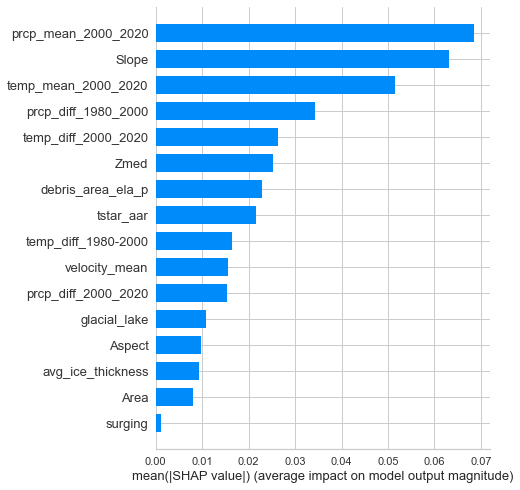

In [271]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")


In [272]:
# Get feature importances in dataframe
feature_names = X.columns


rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
11,prcp_mean_2000_2020,0.068600
4,Slope,0.063180
9,temp_mean_2000_2020,0.051564
13,prcp_diff_1980_2000,0.034252
8,temp_diff_2000_2020,0.026234
6,Zmed,0.025350
2,debris_area_ela_p,0.022931
7,tstar_aar,0.021546
12,temp_diff_1980-2000,0.016483
3,velocity_mean,0.015610


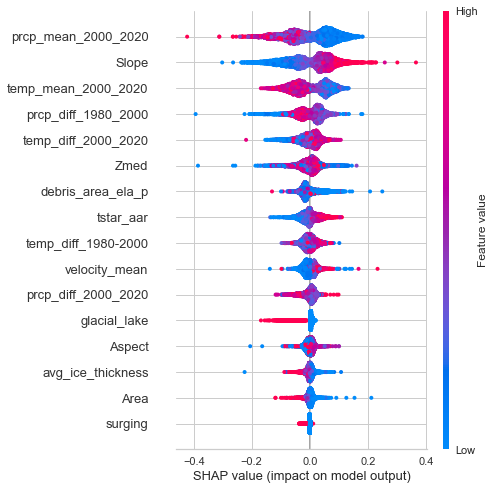

In [273]:
# Make beeswarm plot
shap.summary_plot(shap_values, X)


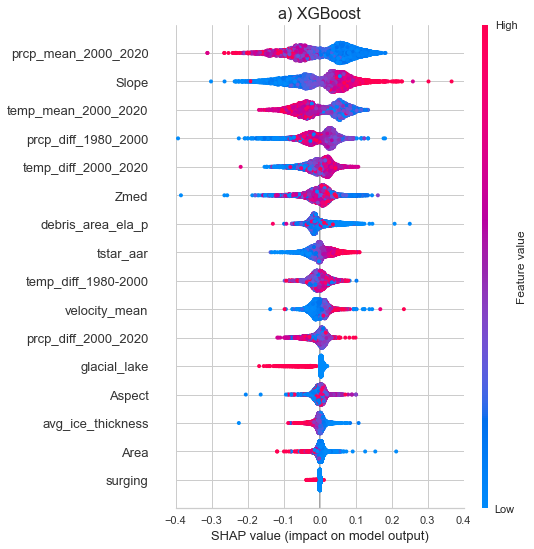

In [320]:
# Limit the x-axis
shap.summary_plot(shap_values, X, show=False)
plt.xlim(-0.4,0.4)
plt.title("a) XGBoost", fontdict={"size":16})
plt.savefig('SHAP_XGBoost.png', bbox_inches='tight', dpi=300)
plt.show()


## prcp_mean_2000_2020 dependency plot of SHAP values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


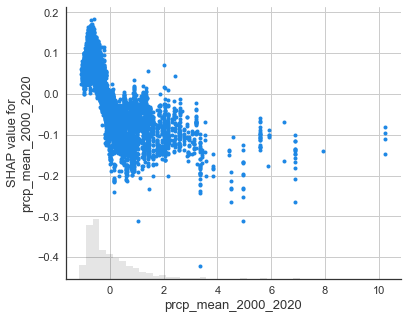

In [512]:
# Dependence plot of prcp_mean_2000_2020
explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.plots.scatter(shap_values[:,"prcp_mean_2000_2020"])

## Debris cover dependency plot of SHAP values## Debris cover 

MAE: 0.114
RMSE 0.163
R2: 0.691


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


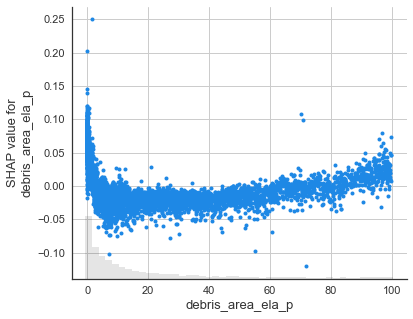

In [515]:
y = np.array(df2000_2020['dmdtda'])

X = df2000_2020[['avg_ice_thickness','Area', 'debris_area_ela_p', 'velocity_mean',
       'Slope', 'Aspect', 'Zmed', 'tstar_aar', 'temp_diff_2000_2020',
       'temp_mean_2000_2020', 'prcp_diff_2000_2020', 'prcp_mean_2000_2020',
       'temp_diff_1980-2000', 'prcp_diff_1980_2000',
                'glacial_lake', 'surging']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 32389)

model = xgb.XGBRegressor(
 n_estimators=1000,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 reg_alpha=1e-05,
 objective= 'reg:squarederror',
 nthread=4,
 scale_pos_weight=1,
 learning_rate =0.01,

 seed=27)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = metrics.r2_score(y_test, y_pred) #Rsquared
mae = np.mean(abs(y_pred - y_test))
rmse = mean_squared_error(y_test, y_pred, squared = False)

explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.scatter(shap_values[:,"debris_area_ela_p"], show = False)
plt.savefig('debris_area_ela_p.png', bbox_inches='tight', dpi=300)
plt.show()

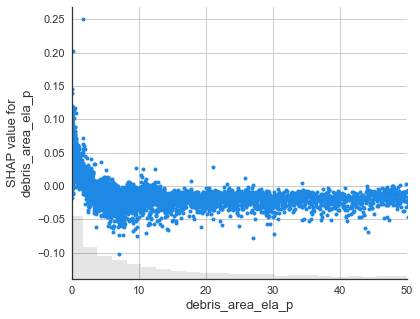

In [517]:
# Limit x-axis
shap.plots.scatter(shap_values[:,"debris_area_ela_p"], show = False)
plt.xlim(0,50)

plt.show()

## Make bar plots of SHAP feature importances of XGBoost and Random Forest models

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


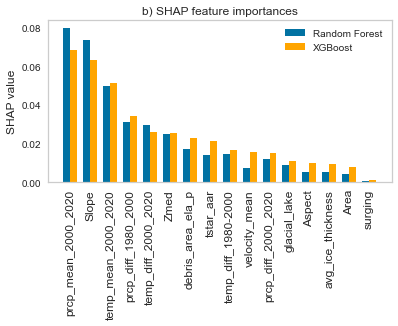

In [316]:
# Data of SHAP values from Random_Forest notebook used
forest_values = [0.079909, 0.073470, 0.049875, 0.031450, 0.029572, 0.024983,
                0.017174, 0.014263, 0.014768, 0.007209, 0.012077, 0.008844, 
                0.005286, 0.005393, 0.004076, 0.000742]
                 

xgb_values = [0.06859981, 0.06317991, 0.0515636 , 0.03425223, 0.02623433,
       0.02535029, 0.02293114, 0.02154602, 0.01648333, 0.01561007,
       0.01529983, 0.01090773, 0.00980131, 0.00940945, 0.00795106,
       0.00111014]
labels = ['prcp_mean_2000_2020', 'Slope', 'temp_mean_2000_2020',
       'prcp_diff_1980_2000', 'temp_diff_2000_2020', 'Zmed',
       'debris_area_ela_p', 'tstar_aar', 'temp_diff_1980-2000',
       'velocity_mean', 'prcp_diff_2000_2020', 'glacial_lake', 'Aspect',
       'avg_ice_thickness', 'Area', 'surging']



x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, forest_values, width, label='Random Forest')
rects2 = ax.bar(x + width/2, xgb_values, width, label='XGBoost', color = 'orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('SHAP value',  fontsize=12)
ax.set_xticks(x, labels, rotation='vertical', fontsize=12)
ax.legend()
plt.title("b) SHAP feature importances")
plt.grid(b=None)
fig.set_figheight(5)
fig.set_figwidth(6)
fig.tight_layout()

plt.savefig('SHAP_feature_importance.png', bbox_inches='tight', dpi=300)

plt.show()

## Compute feature importences with permutation feature importance measure## Permutation feature importance

In [ ]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(
    model, X, y, n_repeats=100, random_state=58311, n_jobs=2
)
xgb_importances = pd.Series(result.importances_mean, index=feature_list)
xgb_importances = xgb_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
xgb_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
fig.set_figheight(4)
fig.set_figwidth(6)
plt.show()

In [500]:
xgb_importances

prcp_mean_2000_2020    0.248030
Slope                  0.199113
temp_mean_2000_2020    0.157512
Zmed                   0.138409
prcp_diff_1980_2000    0.109018
temp_diff_2000_2020    0.085402
temp_diff_1980-2000    0.063283
debris_area_ela_p      0.057154
prcp_diff_2000_2020    0.049892
tstar_aar              0.049722
velocity_mean          0.040680
Aspect                 0.029080
avg_ice_thickness      0.026909
Area                   0.024150
glacial_lake           0.018616
surging                0.001640
dtype: float64

## Make bar plots of permutation feature importances of XGBoost and Random Forest models


The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


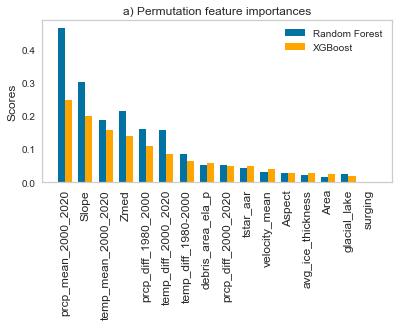

In [314]:
forest_values = [0.465181, 0.302271, 0.188562, 0.214049, 0.160096,
                 0.156380, 0.085776, 0.052646, 0.052048, 0.043120, 0.031496,
                 0.027245,  0.022118,  0.015921, 0.025831, 0.000892]
                 

xgb_values = [0.2480299 , 0.19911348, 0.15751186, 0.13840943, 0.10901839,
       0.08540171, 0.06328299, 0.05715441, 0.0498917 , 0.04972174,
       0.04067991, 0.02908013, 0.02690942, 0.0241496 , 0.01861577,
       0.00164021]
labels = ['prcp_mean_2000_2020', 'Slope', 'temp_mean_2000_2020', 'Zmed',
       'prcp_diff_1980_2000', 'temp_diff_2000_2020', 'temp_diff_1980-2000',
       'debris_area_ela_p', 'prcp_diff_2000_2020', 'tstar_aar',
       'velocity_mean', 'Aspect', 'avg_ice_thickness', 'Area', 'glacial_lake',
       'surging']



x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, forest_values, width, label='Random Forest')
rects2 = ax.bar(x + width/2, xgb_values, width, label='XGBoost', color = 'orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores',  fontsize=12)
ax.set_xticks(x, labels, rotation='vertical', fontsize=12)
ax.legend()
plt.title("a) Permutation feature importances")
plt.grid(b=None)
fig.set_figheight(5)
fig.set_figwidth(6)
fig.tight_layout()

plt.savefig('feature_importance.png', bbox_inches='tight', dpi=300)

plt.show()

## Predicted vs Actual plot

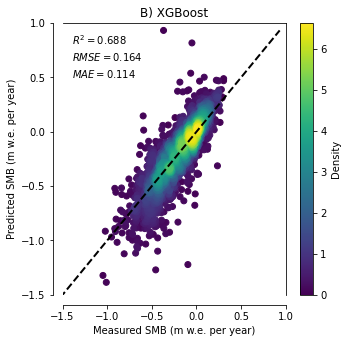

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots(figsize=(5,5))
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.scatter(x, y, c=z, **kwargs )
    ax.spines["left"].set_position(("outward", 10))
    ax.spines["bottom"].set_position(("outward", 10))
    ax.set_xlim([-1.5,1])
    ax.set_ylim([-1.5,1])
    ax.set_xlabel("Measured SMB (m w.e. per year)")
    ax.set_ylabel("Predicted SMB (m w.e. per year)")
    ax.annotate("$R^2={:.3f}$".format(r2), (-1.4, 0.8))
    ax.annotate("$RMSE={:.3f}$".format(rmse), (-1.4, 0.65))
    ax.annotate("$MAE={:.3f}$".format(mae), (-1.4, 0.5))
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--k", linewidth=2)
    plt.title("B) XGBoost")
 
    
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')
    plt.savefig('xgboost.png', bbox_inches='tight', dpi=300)

    return ax


if "__main__" == __name__ :
    density_scatter(y_pred, y_test, bins = [30,30] )

## Plot residuals of XGBoost model

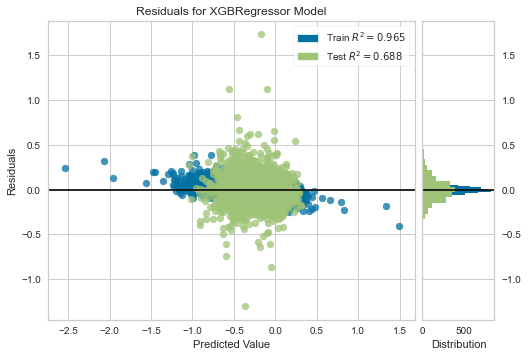

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [125]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()